# Example Bayesian Inference with a Two Parameter Model

In [22]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.stats import norm
import random as rnd
from scipy.stats import beta

In [62]:
# Truncated normal: mean mu, sd sigma, truncated between a and b
def randTNorm(a,b,mu,sigma):
    [aStd,bStd]=[(a - mu) / sigma, (b - mu) / sigma]
    return (truncnorm.rvs(aStd, bStd)*sigma+mu)

def pdfTNorm(a,b,mu,sigma,x): # calculate the pdf of x
    return truncnorm.pdf((x-mu)/sigma, (a-mu)/sigma, (b-mu)/sigma)/sigma
def cdfTNorm(a,b,mu,sigma,x):
    return truncnorm.cdf((x-mu)/sigma, (a-mu)/sigma, (b-mu)/sigma)
def round_up_to_even(x):
    return math.ceil(x / 2.) * 2

## Simulating the Data and Defining the Liklihood and Priors

Here we consider a 2-state DTDS Markov chain with a transition probability matrix:
$$
M=\begin{bmatrix}1-a & a \\ b & 1-b\end{bmatrix}
$$

Suppose we are interested in estimating the values of $a$ and $b$ given a sample trajectory of 50 data points (plus the initial condition which we assume to be in state 0).

In [2]:
def simData(a,b,npts):
    Mmtrx=np.array([[1-a,a],[b,1-b]])
    xList=np.zeros(npts+1, dtype=int)
    for t in range(1,npts):
        xList[t]=rnd.choices([0,1], weights=Mmtrx[xList[t-1]])[0]
    return xList

Creating one example data set.

In [280]:
dataTest=simData(0.1,0.8,50)  #A single true data set
nullData=[] #An empty data set used for testing

### Deifning the likelihood and the prior

Calculating the likleihood and log-likelihood for practice

In [15]:
def Lik(a,b,data):
    Mmtrx=np.array([[1-a,a],[b,1-b]])
    n=data.size
    out=1
    for t in range(1,n):
        out*=Mmtrx[data[t-1],data[t]]
    return out

In [16]:
Lik(0.1,0.2,dataTest)

3.0237106023979756e-08

In [21]:
math.log(Lik(0.1,0.2,dataTest))

-17.31419599047986

In [17]:
def LnLik(a,b,data):
    Mmtrx=np.array([[1-a,a],[b,1-b]])
    n=data.size
    out=0
    for t in range(1,n):
        out+=np.log(Mmtrx[data[t-1],data[t]])
    return out

In [20]:
LnLik(0.1,0.2,dataTest)

-17.31419599047985

Creating a prior for $a$ and $b$

In [23]:
def BetaPrior(mean, variance,x):
    # Calculate alpha from mean
    alpha = ((1 - mean) / variance - 1 / mean) * mean**2
    # Calculate beta from alpha and mean
    beta = alpha * (1 / mean - 1)
    return beta.pdf(x, alpha, beta)

We can sampling randomly from the prior using the function

In [170]:
def BetaRand(mean, variance):
    # Calculate alpha from mean
    alpha = ((1 - mean) / variance - 1 / mean) * mean**2
    # Calculate beta from alpha and mean
    beta = alpha * (1 / mean - 1)
    return np.random.beta(alpha, beta)

Plotting

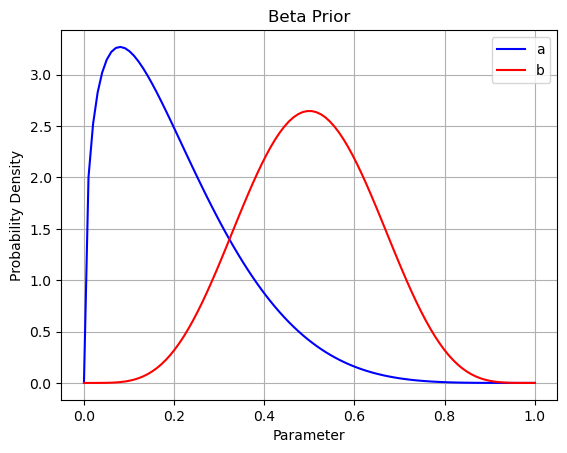

In [284]:
# Generate x values
x_values = np.linspace(0, 1, 100)  # 100 points between 0 and 1
# Generate y values
y_values1 = BetaPrior(0.2, 0.02,x_values)
y_values2 = BetaPrior(0.5, 0.02,x_values)

# Plot the function
plt.plot(x_values, y_values1,'b',label='a')
plt.plot(x_values, y_values2,'r',label='b')
plt.xlabel('Parameter')
plt.ylabel('Probability Density')
plt.title('Beta Prior')
plt.legend()
plt.grid(True)
plt.show()

## Metropolis-Hastings Algorithm 

In [271]:
class Theta:
    def __init__(self,dataIn, a=0.2,b=0.5,jmpRatio=5):  #Initializing the class
        self.nPar=2
        self.cnt=0
        self.next=None # pointer for linked list
        self.a= a #default parameters
        self.b= b #default parameters
        #Jump Distribution and Prior
        self.aDict={"min":0,"max":1,"jmpVar":1.0/jmpRatio, "PriorMean":0.2,"PriorVar":0.01} 
        self.bDict={"min":0,"max":1,"jmpVar":1.0/jmpRatio, "PriorMean":0.5,"PriorVar":0.01}
        #data
        self.data=np.array(dataIn)
        #Calc Probabilities
        self.jump(self)
        self.calcLnLik()
        self.calcLnPrior()
    def randTheta(self):#Create an initial random theta
        # rnd.seed(10) #set random seed
        # self.a=rnd.uniform(self.aDict["min"],self.aDict["max"]) 
        # self.b=rnd.uniform(self.bDict["min"],self.bDict["max"]) 
        self.a=BetaRand(self.aDict["PriorMean"], self.aDict["PriorVar"])
        self.b=BetaRand(self.bDict["PriorMean"], self.aDict["PriorVar"])
        self.jump(self)
        self.calcLnLik()
        self.calcLnPrior()
    def jump(self, parent): #Create a proposed model by jumping from a given parent
        self.cnt=parent.cnt+1
        self.a=randTNorm(self.aDict["min"],self.aDict["max"],parent.a,self.aDict["jmpVar"])
        self.b=randTNorm(self.bDict["min"],self.bDict["max"],parent.b,self.bDict["jmpVar"])
        # self.a=rnd.random()
        # self.b=rnd.random()
        self.calcLnLik()
        self.calcLnPrior()
        self.calcJumpProb(parent)
    # Metropolis Hasting probability
    def calcJumpProb(self,parent):
        #Calculate the forward jump probability
        self.jmpProbF=1
        self.jmpProbF*=pdfTNorm(parent.aDict["min"],parent.aDict["max"],parent.a,parent.aDict["jmpVar"],self.a)
        self.jmpProbF*=pdfTNorm(parent.bDict["min"],parent.bDict["max"],parent.b,parent.bDict["jmpVar"],self.b)
        #Calculate the backward jump probability
        self.jmpProbB=1
        self.jmpProbB*=pdfTNorm(self.aDict["min"],self.aDict["max"],self.a,self.aDict["jmpVar"],parent.a)
        self.jmpProbB*=pdfTNorm(self.bDict["min"],self.bDict["max"],self.b,self.bDict["jmpVar"],parent.b)
        #Calculate Acceptance Ratio
        self.lnr=self.lnLik-parent.lnLik+self.lnPrior-parent.lnPrior+math.log(self.jmpProbF)-math.log(self.jmpProbB)
    def calcLnPrior(self):
        self.lnPrior=BetaPrior(self.aDict["PriorMean"], self.aDict["PriorVar"],self.a)*BetaPrior(self.bDict["PriorMean"], self.bDict["PriorVar"],self.b)
        self.lnPrior=math.log(self.lnPrior)
    def calcLnLik(self):
        Mmtrx=np.array([[1-self.a,self.a],[self.b,1-self.b]])
        n=self.data.size
        out=0
        for t in range(1,n):
            out+=np.log(Mmtrx[self.data[t-1],self.data[t]])
        self.lnLik=out
    def printTheta(self,name,parent):
        nDig=3 #print out to 3 digits
        print(name)
        print('Par a: {}, Par b: {}, Par LogPrior: {}, Par lnLik: {}'.format(round(parent.a,nDig),round(parent.b,nDig),round(parent.lnPrior,nDig),round(parent.lnLik,nDig)))
        print('Forward: {}, Backward: {}, accept prob: {}'.format(round(math.log(self.jmpProbF),nDig),round(math.log(self.jmpProbB),nDig),round(self.lnr,nDig)))
        print('a: {}, b: {}, LogPrior: {}, lnLik: {}'.format(round(self.a,nDig),round(self.b,nDig),round(self.lnPrior,nDig),round(self.lnLik,nDig)))

In [272]:
modelTest=Theta(nullData)
modelTest.printTheta('Test Model',modelTest)

Test Model
Par a: 0.522, Par b: 0.398, Par LogPrior: -1.545, Par lnLik: 0
Forward: 1.419, Backward: 1.419, accept prob: 0.0
a: 0.522, b: 0.398, LogPrior: -1.545, lnLik: 0


In [273]:
class chain:
    def __init__(self,dataIn):
        self.data=np.array(dataIn)
        self.sampleInitial()
        self.nPar=self.headval.nPar
    def sampleInitial(self):
        theta1=Theta(self.data)
        theta1.randTheta()
        self.headval=theta1
        # self.headval.printTheta("Initial Model",self)      
    def MHChain(self,nRep): #simulate chain using the Metropolis-Hastings Algorithm
        self.nRep=nRep
        wrkTheta=self.headval
        t=1 # counter of the reps
        acc=0 # conter of accepted jumps
        fail=0 # conter of rejected jumps
        jmpRatio=20 # jump Ratio
        while t<nRep: 
            propTheta=Theta(self.data,jmpRatio=jmpRatio) #propose a theta
            propTheta.jump(wrkTheta)
            temp=rnd.random()
             # if (t+1)%(min(nRep/2,50))==0:
             #        propTheta.printTheta('Step {}'.format(t),wrkTheta)   
            if temp<math.exp(propTheta.lnr): #accept
                # print('accept')
                t+=1
                acc+=1
                if (t+1)%(min(nRep/2,50))==0: #priting out progress
                    propTheta.printTheta('Step {}'.format(t),wrkTheta)
                wrkTheta.next=propTheta #link list
                wrkTheta=wrkTheta.next #step along
            else:
                # print('reject')
                fail+=1
                
    def printChain(self,biRatio): #convert the linked list into an np array of parameter values
        out=np.empty((self.nRep,self.nPar),dtype=np.double)
        wrkTheta=self.headval
        for row in range(self.nRep):
            out[row][0]=wrkTheta.a
            out[row][1]=wrkTheta.b
            wrkTheta=wrkTheta.next
        #Handelling burnin (bi)
        self.biRep=round_up_to_even(self.nRep*biRatio)
        #print('chain length: {}, biRep: {}, n: {}\n'.format(len(out),self.biRep,self.n))
        self.psiList=out[self.biRep:] #posterior chain
        self.biList=out[:self.biRep] #burnin chain
    def plotChain(self,var,ax,biRatio): # plot mixing within var 'var' in a chain
        self.printChain(biRatio)
        #fig, ax = plt.subplots()
        ax.plot(range(0,self.biRep),self.biList[:,var],color='skyblue',alpha=0.5);
        ax.plot(range(self.biRep,self.nRep),self.psiList[:,var],color='blue');
    def calcKDE(self,biRatio,nBin=1000,a=50): # calculate the kernal density estimate from the chain
        self.printChain(biRatio)
        self.KDEList=np.empty((self.nPar,2,nBin),dtype=np.double)
        for var in range(0,self.nPar):
            self.KDEList[var][0]= np.linspace(min(self.psiList[:,var]), max(self.psiList[:,var]), nBin)
            dx=self.KDEList[var][0][1]-self.KDEList[var][0][0]
            self.KDEList[var][1] = sum(norm(xi,dx*a).pdf(self.KDEList[var][0]) for xi in self.psiList[:,var])#smooth out over 50 of the 1000 intervals
            tot=sum(np.multiply(self.KDEList[var][1],dx))
            self.KDEList[var][1]/=tot
    def findCI(self,var): # find the credible interval
        [x_d,kde]=self.KDEList[var]
        dx=self.KDEList[var][0][1]-self.KDEList[var][0][0]
        #index = np.lexsort((x_d,kde))
        index = np.lexsort((x_d,kde))[::-1] #sort (from largest to smallest) by kde then by x_d 
        self.maxPost=[x_d[index[0]],kde[index[0]]] #maximum posterior estimate
        temp=np.add.accumulate(kde[index]*dx)
        temp2=index[[i for i,v in enumerate(temp) if v < 0.95]] #find pts in credible interval
        indexRev = np.lexsort((kde[temp2],x_d[temp2]))[::-1] #sort (from largest to smallest) by x_d then by kde 
        return [list(x_d[temp2][indexRev]),list(kde[temp2][indexRev])]
    def kdeHist(self,var,ax,biRatio): # plot hisogram of parameter estimate from an individual chain
        self.calcKDE(biRatio)
        [x_d,kde]=self.KDEList[var]
        #plt.fill_between(x_d, density, alpha=0.5) #plot filled smoothed kernel density
        ax.hist(self.psiList[:,var], bins=30,density=True, color = "skyblue",alpha=0.3) #plot histogram
        ax.plot(x_d,kde,'k') #plot smoothed kernel density line
        temp=self.findCI(var)
        ax.scatter(temp[0],temp[1],color='pink',alpha=1,marker=".") #plot credible interval
        ax.plot([self.maxPost[0],self.maxPost[0]],[0, max(kde)*1.2],'r')# Show maximum posterior estimate
#       ax.plot([pars.iloc[0,var],pars.iloc[0,var]],[0, max(kde)*1.2],'g')# Show true value
        ax.plot(self.psiList[:,var], np.full_like(self.psiList[:,var],-max(kde)*0.05), '|k', markeredgewidth=1) #plot hashes at bottom
        ax.axis([min(x_d), max(x_d), -2*max(kde)*0.05, max(kde)*1.2]);

Running the Metropolis-Hasting Chain

### Sampling from the prior

In [274]:
chainTest=chain(nullData)
chainTest.MHChain(2000)

Step 49
Par a: 0.137, Par b: 0.495, Par LogPrior: 2.752, Par lnLik: 0
Forward: 4.067, Backward: 4.069, accept prob: -0.034
a: 0.128, b: 0.514, LogPrior: 2.721, lnLik: 0
Step 99
Par a: 0.388, Par b: 0.591, Par LogPrior: 0.675, Par lnLik: 0
Forward: 3.989, Backward: 3.989, accept prob: 0.348
a: 0.36, b: 0.592, LogPrior: 1.023, lnLik: 0
Step 149
Par a: 0.108, Par b: 0.555, Par LogPrior: 2.506, Par lnLik: 0
Forward: 3.004, Backward: 3.031, accept prob: -0.087
a: 0.087, b: 0.482, LogPrior: 2.446, lnLik: 0
Step 199
Par a: 0.157, Par b: 0.622, Par LogPrior: 2.09, Par lnLik: 0
Forward: 2.713, Backward: 2.713, accept prob: -1.392
a: 0.156, b: 0.707, LogPrior: 0.699, lnLik: 0
Step 249
Par a: 0.241, Par b: 0.496, Par LogPrior: 2.466, Par lnLik: 0
Forward: 4.043, Backward: 4.043, accept prob: -0.113
a: 0.255, b: 0.476, LogPrior: 2.353, lnLik: 0
Step 299
Par a: 0.145, Par b: 0.61, Par LogPrior: 2.216, Par lnLik: 0
Forward: 4.075, Backward: 4.074, accept prob: 0.031
a: 0.165, b: 0.607, LogPrior: 2.2

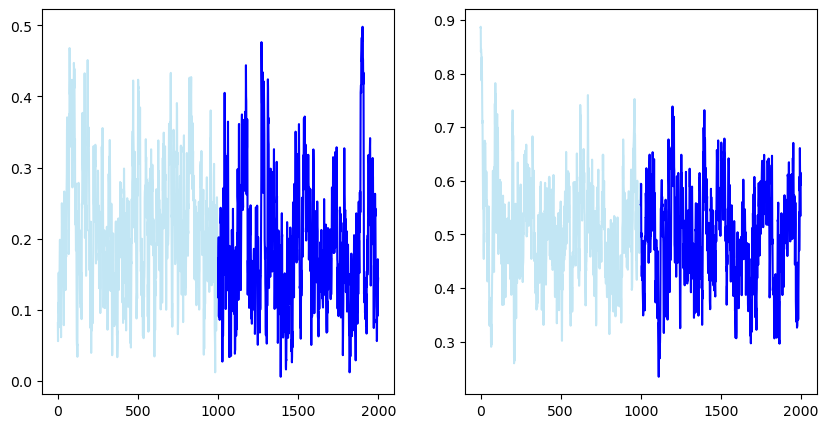

In [275]:
fig, ax0 =  plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for v in range(2):
    chainTest.plotChain(v,ax0[v],0.5)

Plotting the posteriors

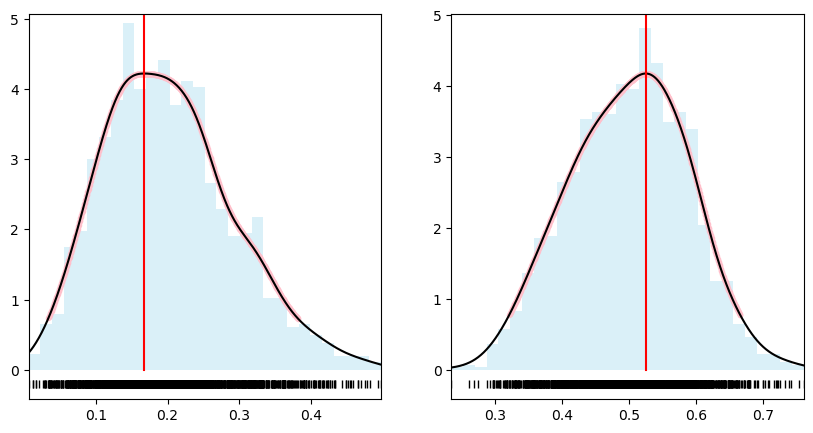

In [276]:
fig, ax1 =  plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
chainTest.calcKDE(0.2,nBin=1000,a=50)
for v in range(2):
    chainTest.findCI(v)
    chainTest.kdeHist(v,ax1[v],0.2)

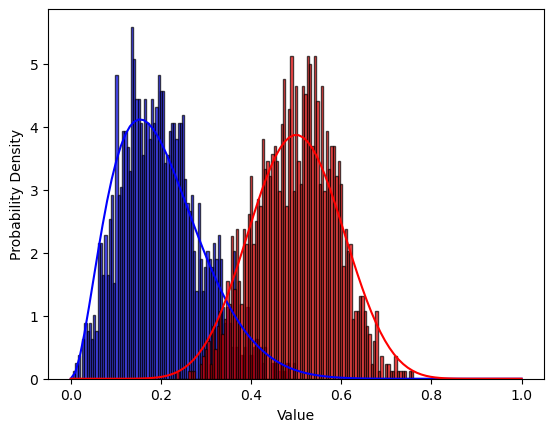

In [277]:
# Generate x values
x_values = np.linspace(0, 1, 100)  # 100 points between 0 and 1
# Generate y values
y_values1 = BetaPrior(0.2, 0.01,x_values)
y_values2 = BetaPrior(0.5, 0.01,x_values)

# Plot the function
plt.plot(x_values, y_values1,'b')
plt.plot(x_values, y_values2,'r')
plt.hist(chainTest.psiList[:,0], bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.hist(chainTest.psiList[:,1], bins=100, density=True, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Probability Density');

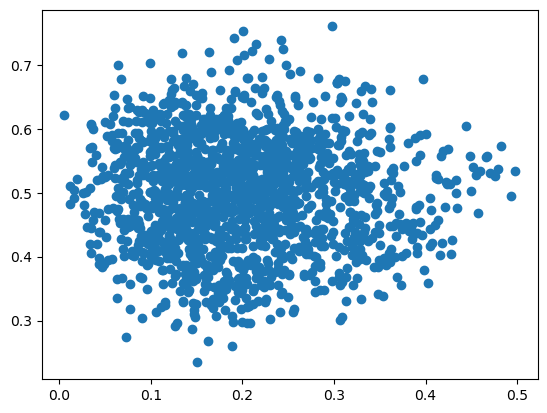

In [278]:
plt.scatter(chainTest.psiList[:,0],chainTest.psiList[:,1])

## Sampling from posterior

In [279]:
chainTest=chain(dataTest)
chainTest.MHChain(2000)

Step 49
Par a: 0.05, Par b: 0.54, Par LogPrior: 1.717, Par lnLik: -12.482
Forward: 4.235, Backward: 4.25, accept prob: 0.075
a: 0.047, b: 0.518, LogPrior: 1.699, lnLik: -12.374
Step 99
Par a: 0.049, Par b: 0.37, Par LogPrior: 0.996, Par lnLik: -11.979
Forward: 3.84, Backward: 3.945, accept prob: -0.33
a: 0.034, b: 0.417, LogPrior: 0.912, lnLik: -12.12
Step 149
Par a: 0.118, Par b: 0.461, Par LogPrior: 2.625, Par lnLik: -13.574
Forward: 3.681, Backward: 3.714, accept prob: 0.486
a: 0.087, b: 0.423, LogPrior: 2.198, lnLik: -12.628
Step 199
Par a: 0.19, Par b: 0.511, Par LogPrior: 2.703, Par lnLik: -16.394
Forward: 1.617, Backward: 1.662, accept prob: 2.901
a: 0.086, b: 0.552, LogPrior: 2.329, lnLik: -13.076
Step 249
Par a: 0.065, Par b: 0.512, Par LogPrior: 2.139, Par lnLik: -12.502
Forward: 3.235, Backward: 3.204, accept prob: 0.135
a: 0.075, b: 0.442, LogPrior: 2.156, lnLik: -12.416
Step 299
Par a: 0.134, Par b: 0.399, Par LogPrior: 2.291, Par lnLik: -13.928
Forward: 3.957, Backward: 3

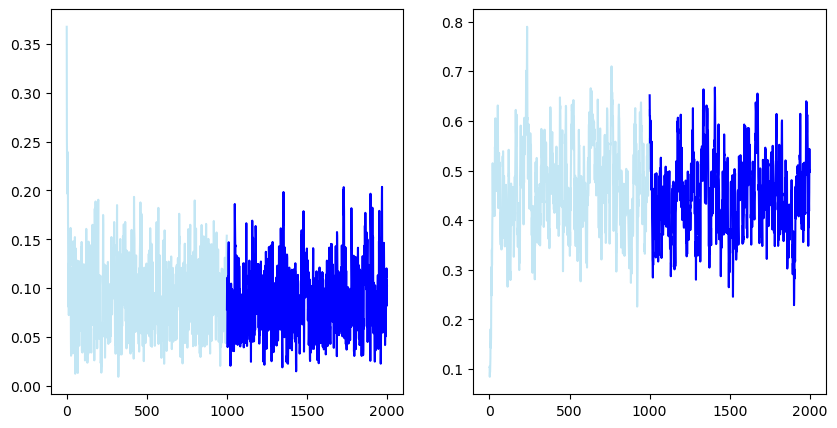

In [281]:
fig, ax0 =  plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for v in range(2):
    chainTest.plotChain(v,ax0[v],0.5)

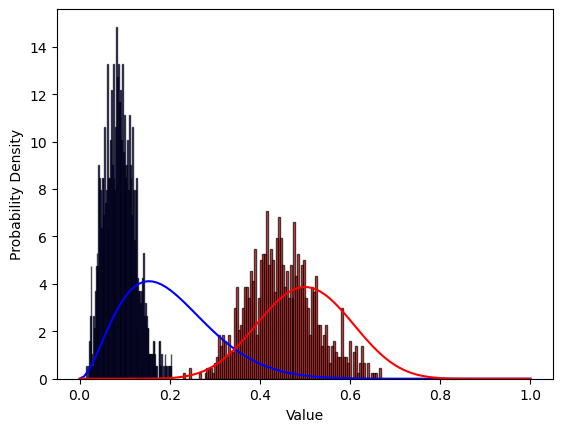

In [282]:
# Generate x values
x_values = np.linspace(0, 1, 100)  # 100 points between 0 and 1
# Generate y values
y_values1 = BetaPrior(0.2, 0.01,x_values)
y_values2 = BetaPrior(0.5, 0.01,x_values)

# Plot the function
plt.plot(x_values, y_values1,'b')
plt.plot(x_values, y_values2,'r')
plt.hist(chainTest.psiList[:,0], bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.hist(chainTest.psiList[:,1], bins=100, density=True, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Probability Density');

0.003321782888233707


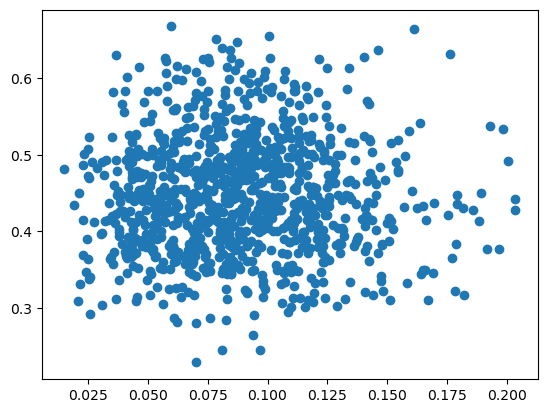

In [287]:
plt.scatter(chainTest.psiList[:,0],chainTest.psiList[:,1])
correlation = np.corrcoef(chainTest.psiList[:,0], chainTest.psiList[:,1])[0, 1]
print(correlation)